# Import the required modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

C:\Users\aman9\AppData\Local\Temp\ipykernel_4940\619629230.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

# number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [4]:
number_of_samples = 50000

# Read data from attack and normal datasets.

In [5]:
data_attack = pd.read_csv('dataset_attack.csv', nrows = number_of_samples)

In [6]:
data_normal = pd.read_csv('dataset_normal.csv', nrows = number_of_samples)

In [7]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

# Drop unwanted columns

In [8]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [9]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [10]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

# Standardise the data

In [11]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

# the class field, replace value 'attack' with 0 and 'normal' with 1

In [12]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1
    

After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [13]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [14]:
X.shape

(100000, 25)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

The architecture used is 
![Model](model_brnn.png)

In [16]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [18]:
model = create_baseline()

In [21]:
import numpy as np

X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)


In [ ]:
from keras.utils import to_categorical

# Assuming Y_train is originally in shape (samples, )
# One-hot encode the labels
Y_train = to_categorical(Y_train, num_classes=28)  # Replace 2 with the actual number of classes

# Now, Y_train will have the shape (samples, 2)


In [ ]:
# X_train = X_train.astype('float32') / 255.0  # Normalize to [0, 1]


In [ ]:
# from keras.utils import to_categorical

# Y_train = to_categorical(Y_train)


In [ ]:
# # For binary classification
# model.add(Dense(1, activation='sigmoid'))

# # For multi-class classification (assuming 2 classes)
# model.add(Dense(2, activation='softmax'))


In [22]:
history = model.fit(X_train, Y_train, epochs = 40,validation_split=0.2, verbose = 1)

Epoch 1/40


2000/2000 [==============================] - 19s 8ms/step - loss: 0.3023 - accuracy: 0.9317 - val_loss: 0.2132 - val_accuracy: 0.9455
Epoch 2/40
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1779 - accuracy: 0.9568 - val_loss: 0.1560 - val_accuracy: 0.9616
Epoch 3/40
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1535 - accuracy: 0.9635 - val_loss: 0.1407 - val_accuracy: 0.9652
Epoch 4/40
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1491 - accuracy: 0.9641 - val_loss: 0.1756 - val_accuracy: 0.9545
Epoch 5/40
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1382 - accuracy: 0.9669 - val_loss: 0.1452 - val_accuracy: 0.9688
Epoch 6/40
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1333 - accuracy: 0.9674 - val_loss: 0.1283 - val_accuracy: 0.9679
Epoch 7/40
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1300 - accuracy: 0.9687 - val_loss: 0.1283 - val_

Obtained plot of accuracy

![plot of accuracy](BRNN_Model_Accuracy.png)

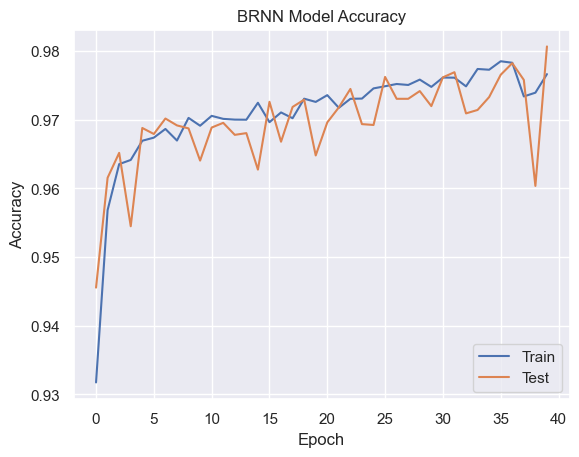

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

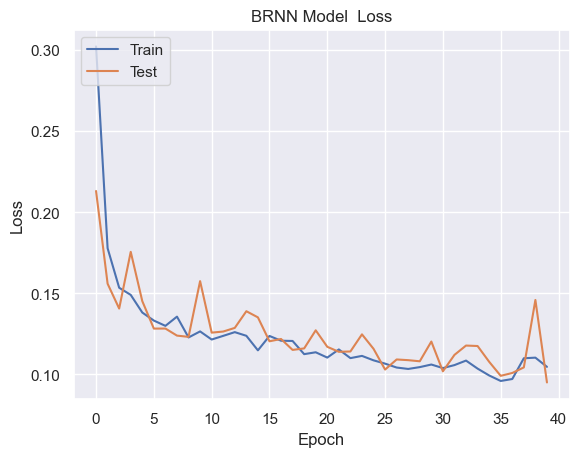

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()


In [26]:
predict = model.predict(X_test, verbose=1)

625/625 [==============================] - 5s 7ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [27]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


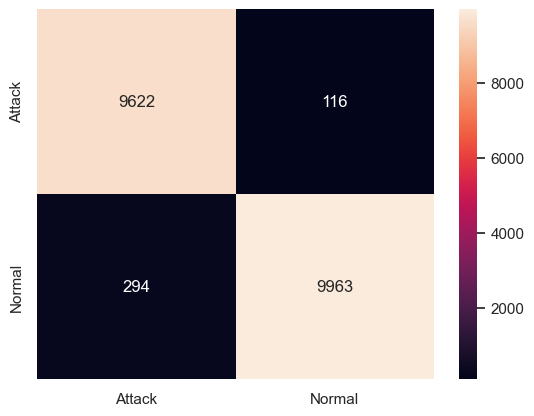

In [28]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details 

In [29]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [31]:
model.save('brnn_model.h5')

In [37]:
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)


In [40]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.95%


In [39]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('brnn_model.h5')

# Define the input pipeline
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.shuffle(buffer_size=10000)
train_data = train_data.batch(batch_size=32)
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the validation pipeline
val_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_data = val_data.batch(batch_size=32)
val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the test pipeline
test_data = tf.data.Dataset.from_tensor_slices(X_test)
test_data = test_data.batch(batch_size=32)
test_data = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Use the model to make predictions on the test data
predictions = model.predict(test_data)

625/625 [==============================] - 5s 7ms/step
